In [1]:
import os

while "src" not in os.listdir():
    assert "/" != os.getcwd(), "src directory not found"
    os.chdir("..")

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.transforms import Resize

from src.lib.nyu_dataset import NYUDataset
from src.lib.depth_estimator import DepthEstimator
from src.lib.resnet_loader import load_classifier_resnet50, load_contrastive_resnet50

In [2]:
DATA_DIR = "data"
DATASET_FILE = "nyu_depth_v2_labeled.mat"

batch_size = 16
lr = 0.001
epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def transform(color_map, depth_map):
    color_map = torch.from_numpy(color_map).float()
    depth_map = torch.from_numpy(depth_map).float().unsqueeze(0)

    h, w = color_map.shape[1]//2 , color_map.shape[2]//2
    color_map = Resize((h, w))(color_map)
    depth_map = Resize((h, w))(depth_map)
    
    # crop a random 224x224 patch
    h0 = np.random.randint(0, h - 224)
    w0 = np.random.randint(0, w - 224)
    h1 = h0 + 224
    w1 = w0 + 224

    color_map = color_map[:, h0:h1, w0:w1]
    depth_map = depth_map[:, h0:h1, w0:w1]

    color_map /= 255.0
    depth_map /= 2.0
    depth_map -= 1

    return color_map, depth_map


dataset = NYUDataset(os.path.join(DATA_DIR, DATASET_FILE), transform=transform)

n_train, n_val = int(0.8 * len(dataset)), int(0.1 * len(dataset))
n_test = len(dataset) - n_train - n_val

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [4]:
model = DepthEstimator(load_contrastive_resnet50("pretrained_models/resnet50_imagenet_bs2k_epochs600.pth.tar")).to(device)

IMAGENET_PATH = /home/aashukha/imagenet/raw-data/
======> Encoder: output dim 2048 | 25.557M parameters


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [6]:
validation_loss_history = []
loss_history = []

for epoch in range(epochs):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))    
    for i, (color_map, depth_map) in pbar:
        color_map = color_map.to(device)
        depth_map = depth_map.to(device)

        pred = model(color_map)
        loss = loss_fn(pred, depth_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # update pbar description with batch and loss
        pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Batch {i + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    # compute validation loss
    val_loss = 0
    for i, (color_map, depth_map) in enumerate(val_loader):
        color_map = color_map.to(device)
        depth_map = depth_map.to(device)

        pred = model(color_map)
        val_loss += loss_fn(pred, depth_map).item()
    val_loss /= len(val_loader)

    validation_loss_history.append(val_loss)
    # display validation loss
    print(f"Epoch {epoch + 1}/{epochs} - Validation Loss: {val_loss:.4f}")


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 1/100 - Validation Loss: 0.2614


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2/100 - Validation Loss: 0.2304


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3/100 - Validation Loss: 0.2274


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 4/100 - Validation Loss: 0.2124


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 5/100 - Validation Loss: 0.2053


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 6/100 - Validation Loss: 0.2115


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 7/100 - Validation Loss: 0.1909


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 8/100 - Validation Loss: 0.1819


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 9/100 - Validation Loss: 0.2003


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 10/100 - Validation Loss: 0.1873


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 11/100 - Validation Loss: 0.1938


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 12/100 - Validation Loss: 0.2063


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 13/100 - Validation Loss: 0.1976


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 14/100 - Validation Loss: 0.1918


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 15/100 - Validation Loss: 0.1769


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 16/100 - Validation Loss: 0.1789


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 17/100 - Validation Loss: 0.1967


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 18/100 - Validation Loss: 0.1875


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 19/100 - Validation Loss: 0.2122


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 20/100 - Validation Loss: 0.1945


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 21/100 - Validation Loss: 0.1858


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 22/100 - Validation Loss: 0.1875


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 23/100 - Validation Loss: 0.1993


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 24/100 - Validation Loss: 0.1879


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 25/100 - Validation Loss: 0.1991


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 26/100 - Validation Loss: 0.1811


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 27/100 - Validation Loss: 0.1890


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 28/100 - Validation Loss: 0.1811


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 29/100 - Validation Loss: 0.1764


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 30/100 - Validation Loss: 0.1816


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 31/100 - Validation Loss: 0.1840


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 32/100 - Validation Loss: 0.1849


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 33/100 - Validation Loss: 0.1875


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 34/100 - Validation Loss: 0.1733


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 35/100 - Validation Loss: 0.1748


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 36/100 - Validation Loss: 0.1837


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 37/100 - Validation Loss: 0.1931


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 38/100 - Validation Loss: 0.1807


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 39/100 - Validation Loss: 0.1781


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 40/100 - Validation Loss: 0.1824


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 41/100 - Validation Loss: 0.1853


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 42/100 - Validation Loss: 0.1650


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 43/100 - Validation Loss: 0.1925


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 44/100 - Validation Loss: 0.1840


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 45/100 - Validation Loss: 0.1749


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 46/100 - Validation Loss: 0.1891


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 47/100 - Validation Loss: 0.1859


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 48/100 - Validation Loss: 0.1878


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 49/100 - Validation Loss: 0.1794


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 50/100 - Validation Loss: 0.1881


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 51/100 - Validation Loss: 0.1804


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 52/100 - Validation Loss: 0.1757


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 53/100 - Validation Loss: 0.1835


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 54/100 - Validation Loss: 0.1911


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 55/100 - Validation Loss: 0.1967


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 56/100 - Validation Loss: 0.1774


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 57/100 - Validation Loss: 0.1793


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 58/100 - Validation Loss: 0.1859


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 59/100 - Validation Loss: 0.1859


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 60/100 - Validation Loss: 0.1816


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 61/100 - Validation Loss: 0.1849


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 62/100 - Validation Loss: 0.1858


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 63/100 - Validation Loss: 0.1844


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 64/100 - Validation Loss: 0.1713


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 65/100 - Validation Loss: 0.1714


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 66/100 - Validation Loss: 0.1684


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 67/100 - Validation Loss: 0.1696


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 68/100 - Validation Loss: 0.1837


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 69/100 - Validation Loss: 0.1830


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 70/100 - Validation Loss: 0.1827


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 71/100 - Validation Loss: 0.1733


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 72/100 - Validation Loss: 0.1694


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 73/100 - Validation Loss: 0.1872


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 74/100 - Validation Loss: 0.1832


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 75/100 - Validation Loss: 0.1797


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 76/100 - Validation Loss: 0.1778


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 77/100 - Validation Loss: 0.1776


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 78/100 - Validation Loss: 0.1974


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 79/100 - Validation Loss: 0.1806


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 80/100 - Validation Loss: 0.1889


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 81/100 - Validation Loss: 0.1759


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 82/100 - Validation Loss: 0.1844


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 83/100 - Validation Loss: 0.1802


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 84/100 - Validation Loss: 0.1743


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 85/100 - Validation Loss: 0.1802


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 86/100 - Validation Loss: 0.1815


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 87/100 - Validation Loss: 0.1942


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 88/100 - Validation Loss: 0.1895


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 89/100 - Validation Loss: 0.1775


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 90/100 - Validation Loss: 0.1938


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 91/100 - Validation Loss: 0.1892


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 92/100 - Validation Loss: 0.1898


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 93/100 - Validation Loss: 0.1789


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 94/100 - Validation Loss: 0.1722


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 95/100 - Validation Loss: 0.1880


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 96/100 - Validation Loss: 0.1954


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 97/100 - Validation Loss: 0.1870


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 98/100 - Validation Loss: 0.1773


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 99/100 - Validation Loss: 0.1912


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch 100/100 - Validation Loss: 0.1844


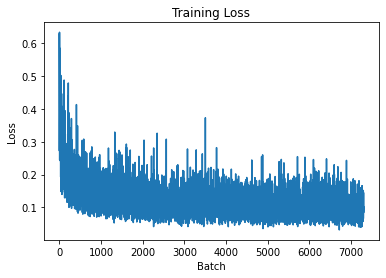

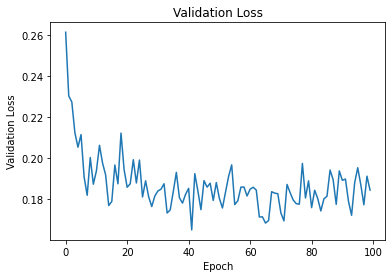

In [7]:
# Plot loss history
plt.plot(loss_history)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Plot validation loss history
plt.plot(validation_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss")
plt.show()

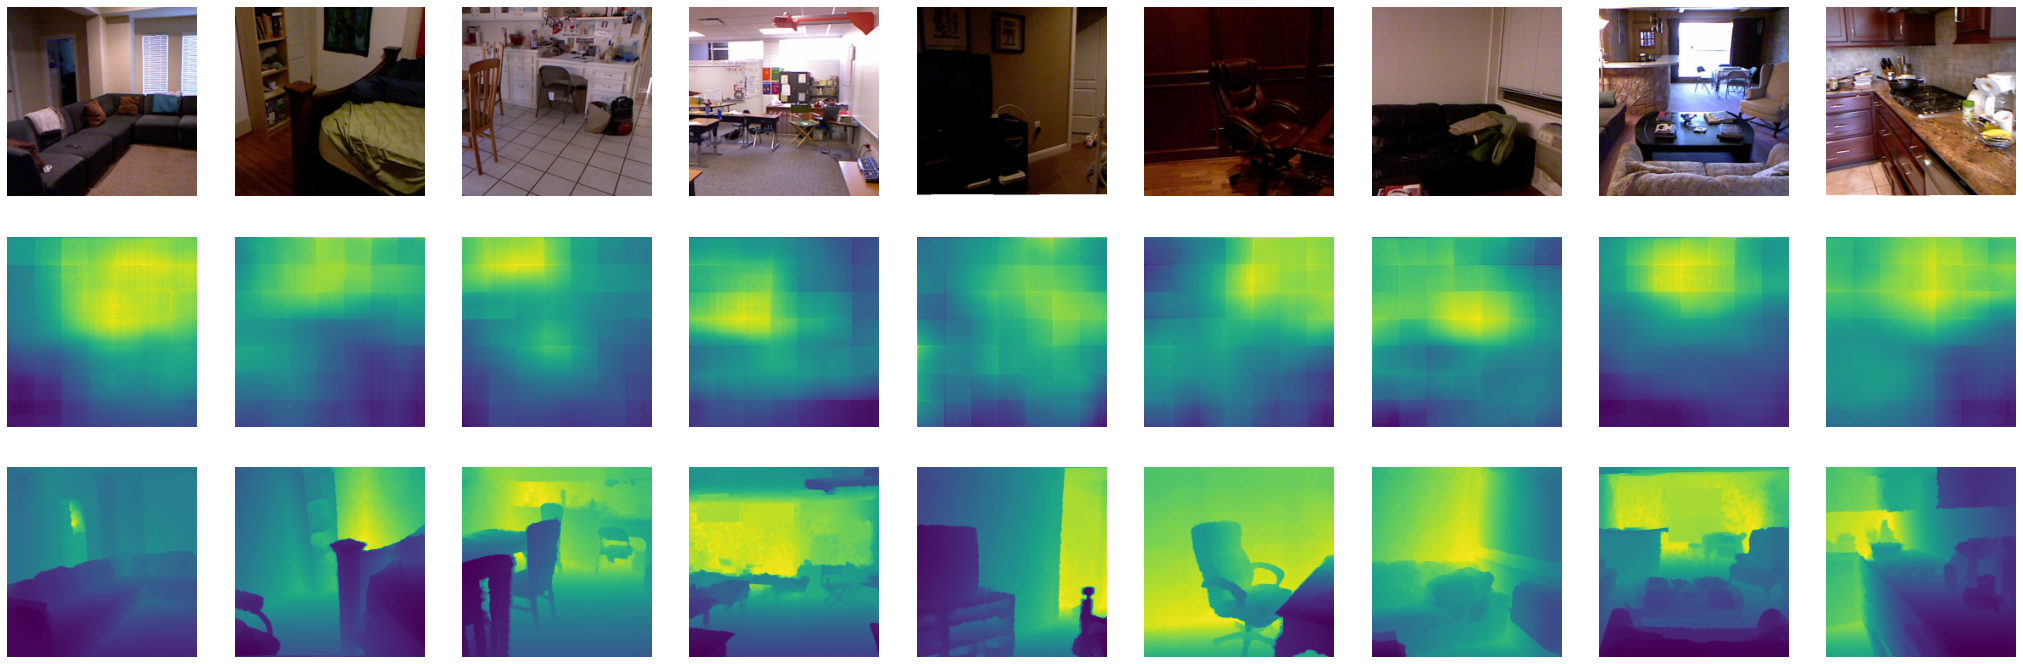

In [8]:
# Visualize the models predictions
# pick 9 random samples
idxs = np.random.choice(len(dataset), 9)
samples = [dataset[idx] for idx in idxs]
color_maps = []
depth_maps = []
preds = []
for color_tensor, depth_tensor in samples:
    # to numpy array
    color_map = color_tensor.cpu().numpy().transpose(1, 2, 0)
    depth_map = depth_tensor.cpu().numpy().squeeze()
    depth_prediction = model(color_tensor.unsqueeze(0).to(device)).cpu().detach().squeeze().numpy()

    color_maps.append(color_map)
    depth_maps.append(depth_map)
    preds.append(depth_prediction)

# plot 3x9 grid of color, depth, and prediction
fig, axes = plt.subplots(3, 9, figsize=(9*4, 3*4))
for i in range(9):
    axes[0, i].imshow(color_maps[i])
    axes[2, i].imshow(depth_maps[i])
    axes[1, i].imshow(preds[i])

for ax in axes.ravel():
    ax.axis("off")

plt.show()
